In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
# MNIST Data set 

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1 ,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape  # 이미지가 28 * 28 픽셀

(70000, 784)

In [5]:
y.shape

(70000,)

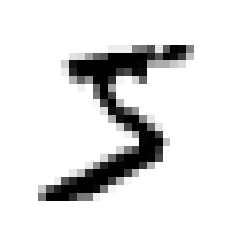

In [6]:
# 샘플의 특성 벡터를 추출해서 28 * 28배열로 크기를 바꾸고 imshow()함수 사용해서 시각화

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
# 레이블은 현재 문자열 , 대부분 머신러닝 알고리즘은 수치형을 받기 때문에 y를 정수로 변환 

y = y.astype(np.int8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    
    size = 28
    images_per_row = min(len(instances), images_per_row)
    
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

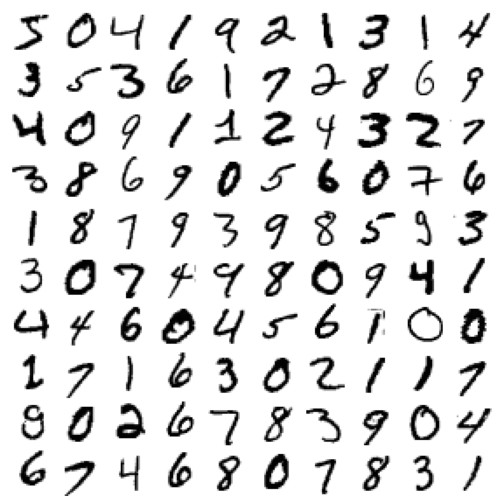

In [11]:
plt.figure(figsize=(9,9))

example_images = X[:100]
plot_digits(example_images, images_per_row=10)

plt.show()

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
y_train = y_train.astype(np.int8)

### 이진 분류기 훈련
* 그렇다 / 아니다 2개로 분류하는 것입니다. 이때 결과가 '그렇다' 이면 1로 표현하고 '아니다'이면 0으로 표현

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#### 확률적 경사 하강법(Stochastic Gradient Descent)  
추출된 데이터 한개에 대해서 그래디언트(기울기)를 계산하고, 경사 하강 알고리즘을 적용하는 방법을 말한다.   

전체 데이터를 사용하는 것이 아니라, 랜덤하게 추출한 일부 데이터를 사용하는 것이다.     

따라서 학습 중간 과정에서 결과의 진폭이 크고 불안정하며, 속도가 매우 빠르다.   

데이터 하나씩 처리하기 때문에 오차율이 크고 GPU의 성능을 모두 활용하지 못하는 단점을 가진다. 이러한 단점들을 보완하기 위해 나온 방법들이 Mini batch를 이용한 방법이며, 확률적 경사 하강법의 노이즈를 줄이면서도 전체 배치보다 더 효율적인 것으로 알려져 있다.   


* Batch는 모든 데이터를 한꺼번에 학습하는데 활용하기 때문에 부드럽게 수렴하나 샘플의 개수만큼 계산해야하기떄문에 시간이 다소 소요된다. 
* Stochastic 방법은 데이터를 한개씩 추출해서 처리해보고 이를 모든 학습데이터에 대해 적용한 것이다. 
* Mini-Batch 는 전체 학습데이터를 배치 사이즈로 나누어서 순차적으로 진행한다. 일반적으로 딥러닝 학습에 사용되는 방법이며, Batch 보다 빠르고 SGD 보다 낮은 오차율을 가진다.

In [15]:
from sklearn.linear_model import SGDClassifier


# SGDClassifier 무작위성을 사용한다.
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### 성능 측정 

#### 교차검증
훈련시 학습데이터에 과도하게 초점을 맞춰 머신이 훈련 될 수 있는데 이 경우에는 훈련데이터에는 예측력이 높지만 실제 테스트데이터에서는 예측력이 떨어지는 과적합이 발생할 수 있다. 과적합을 막기 위해 교차검증 실행  

**교차검증이란 훈련데이터 세트를 바꿔가며 훈련하면서 나온 평균을 정확도로 보는 방법을 뜻한다.**

* StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행한다. 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드를 예측한다. 올바른 예측의 수를 세어 정확한 예측의 비율을 출력  



* StratifiedKFold는 target의 속성값의 개수를 동일하게 가져감으로써 kfold같이 데이터가 한곳으로 몰리는 것을 방지

In [18]:
#교차 검증을 사용한 정확도 측정

from sklearn.model_selection import StratifiedKFold

#동일한 모수를 사용하여 새로운 적합하지 않은 추정량을 생성합니다.
#Clone은 실제로 첨부 된 데이터를 복사하지 않고 추정기에서 모델의 전체 복사를 수행합니다. 
#데이터에 적합하지 않은 동일한 매개 변수를 가진 새로운 추정량을 생성합니다.
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits= 3  ,random_state = 42 , shuffle= True)

for train_index ,test_index in skfolds.split(X_train, y_train_5) :
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_folds  = X_train[test_index]
    y_test_folds  = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds , y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train , y_train_5 , cv = 3 , scoring= 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [20]:
# 모든 이미지를 '5가 아니다 ' 클래스로 분류하는 더미 분류기 생성 후 비교 

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator) : 
    def fit(self , X , y = None) :
        return self
    def predict(self , X) :
        return np.zeros((len(X) ,1) ,dtype = bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

이미지의 10%정도만 숫자 5이기 때문에 무조건 '5가 아니다'로 예측하면 정확히 맞출 확률이 90%정도가 나온다. 이는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다. 특히 불균형한 데이터셋을 다룰때 더욱 그렇다.

### 오차행렬

* 분류기의 성능을 평가하는 더 좋은 방법은 오차행렬을 조사하는 것이다. 기본적인 아이디어는 클래스 A의 샘플이 클래스B로 분류돈 횟수를 세는 것이다. 예를 들어 분류기가 숫자5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차행렬의 5행 3열을 보면 된다.

* 오차행렬을 만들기 위해서는 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다. 테스트셋을 사용할 수 없기 때문에 cross_val_predict()함수를 이용    



* cross_var_predict함수는 k-교차검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다. 즉 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측한다는 의미

In [22]:
from sklearn.model_selection import cross_val_predict

# 예측 클래스
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5 , cv = 3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5 , y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* 오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냅니다.  


* 이 행렬의 첫 번째 행은 '5 아님' 이미지에 대한 것으로 53,892개를 5 아님으로 정확하게 분류(진짜 음성), 나머지 682를 5라고 잘못 분류(거짓 양성)를 했습니다.   


* 이 행렬의 두 번째행은 '5'에 대한 것으로 1891개를 '5 아님'으로 잘못 분류했고(거짓 음성), 3530개를 정확히 '5'라고 분류했습니다(진짜 양성).

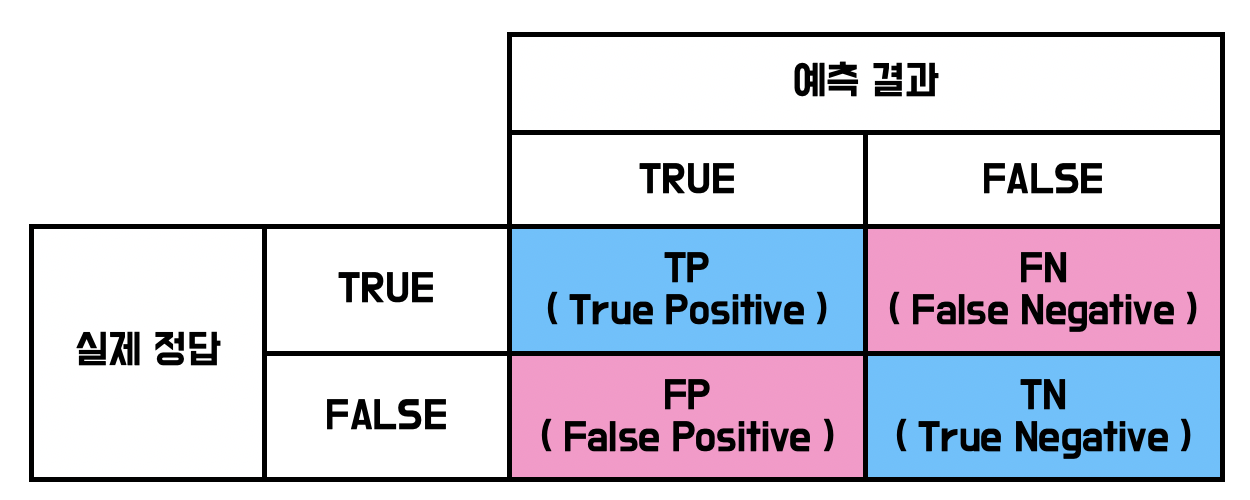

양성예측의 정확도 이를 분류기의 정밀도(precision)라고 한다.  

TP는 양성의 수, FP는 거짓 양성의 수라고 했을 때 정밀도 = TP/(TP+FP)    

확실한 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도를 얻을 수 있지만 이는 분류기가 다른 모든 양성 샘플을 무시하기 때문에 유용하지 않다.  
정밀도는 재현률(recall)이라는 또 다른 지표와 같이 사용하는 것이 일반적이다.  

재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로 민감도(sensitivity) 또는 TPR(True positive rate)이라고도 한다.  
재현율 = TP/(TP+FN) FN은 거짓 음성의 수





### 정밀도, 재현율, F_score

In [24]:
from sklearn.metrics import precision_score , recall_score
precision_score(y_train_5 ,y_train_pred)

0.8370879772350012

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_5 , y_train_pred)

0.7325171197343846

### 정밀도, 재현율 트레이드 오프

* 정밀도와 재현율의 중요성은 사례마다 다르다. 정밀도 혹은 재현율이 특별히 강조되야 하는 경우 , 머신러닝 모델의 임계값(Treshold)를 조정함으로써 정밀도와 재현율의 수치를 높일 수 있다. 하지만 정밀도와 재현율은 서로 상호보완적인 관계이기 때문에 한쪽을 강제로 높이게 되면 다른한쪽은 떨어지게 된다.

* 기본적으로 사이킷런의 이진분류에서는 0.5(50%)를 임계값으로 설정하고 이에 따라 레이블을 예측한다. 즉, 예측 확률이 1로 예측되는 확률이 50%보다 크면 Positive(1)로, 작으면 Negative(0)으로 예측하게 되는 것이다.

In [27]:
# 각 샘플의 점수 확인 

y_score = sgd_clf.decision_function([some_digit])
y_score

array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_score > threshold)

In [29]:
y_some_digit_pred

array([ True])

임계값이 0 이므로 predict() 메서드와 같은결과를 반환

In [30]:
# 임계값을 높일 시 

threshold = 8000
y_some_digit_pred = (y_score> threshold)
y_some_digit_pred

array([False])

이 결과는 임계값을 높이면 재현율이 줄어든다는 것을 보여준다. 이미지가 실제로 숫자 5 이고 임계값이 0일때는 분류기가 이를 감지했지만 , 임곗값을 8000으로 높이면 이를 놓치게 된다.  

**적절한 임계값을 정하기 위해서는 cross_val_predict()함수를 사용해 훈련세트에 있는 모든 샘플의 점수를 구해야 한다. 예측점수가 아니라 결정 점수를 반환하도록 지정**

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

precision_recall_curve()함수를 통해 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산 

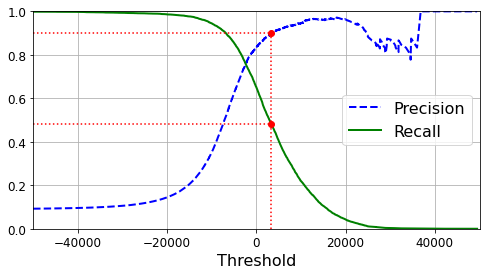

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])             


# np.argmax() 최댓값의 첫번째 인덱스를 반환 
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                  # Not shown
plt.show()

### ROC(Receiver operating characteristic) 곡선 

* ROC 곡선은 false positive rate에 대한 true positive rate의 곡선이다. 양성으로 잘못 분류된 음성 샘플의 비율이 FPR 이는 1에서 음성으로 정확하게 분류된 음성 샘플의 비율인 TNR을 뺀값이다. TNR을 특이도 라고도 한다. 그러므로 ROC 곡선은 민감도에 대한 1-특이도 그래프이기도 하다.

In [34]:
from sklearn.metrics import roc_curve

fpr , tpr , thresholds = roc_curve(y_train_5, y_scores)

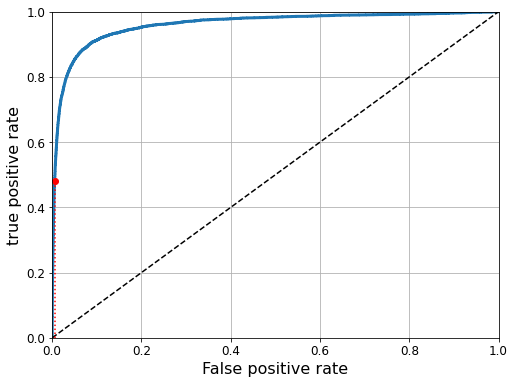

In [35]:
def plot_roc_curve(fpr , tpr , label = None) :
    plt.plot(fpr , tpr , linewidth = 3 , label  = label)
    plt.plot([0,1], [0,1],'k--') # 대각점선 
    plt.axis([0,1, 0,1])
    plt.xlabel('False positive rate', fontsize = 16)
    plt.ylabel('true positive rate', fontsize = 16)
    plt.grid(True)

plt.figure(figsize  = (8,6))
plot_roc_curve(fpr , tpr)

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

plt.plot([fpr_90 , fpr_90] , [0. , recall_90_precision], 'r:')
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([fpr_90], [recall_90_precision],'ro')
plt.show()

모든 가능한 임계값에서 진짜 양성비율에 대한 거짓 양성 비율을 나타낸 ROC 곡선, 붉은 점이 선택한 비율(재현율)

여기서도 트레이드 오프가 있다. 재현율(TPR)이 높을 수록 분류기가 만드는 FPR이 늘어난다. 점선은 완전한 랜덤 분류기의 ROC곡선을 뜻한다.
좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 한다.  

곡선아래의 면적(Area under the curve, AUC)을 측정하면 분류기들을 비교할 수 있다. 완벽한 분류기는 ROC의 AUC가 1이고 ,완전한 랜덤 분류기는 0.5이다. 

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5 , y_scores)

0.9604938554008616

#### 상황에 따른 그래프 선택 

* 일반적인 법칙은 양성클래스가 드물거나 거짓 음성보다 거짓양성이 더 중요할때 PR곡선을 사용하고 그렇지 않으면 ROC곡선을 사용한다. 예를 들어 조금 전의 ROC곡선을 보면 좋은 분류기라고 생각 할 수 있다. 하지만 이는 음성(5아님)이 크게 적기 때문이다. 이 와는 다르게 PR곡선은 분류기의 성능 개선여지가 얼마난 되는지 잘 보여준다.

In [37]:
# 랜덤포레스트를 사용해 sgdclassifier roc곡선과 auc점수를 비교

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state= 42)
y_probas_forest = cross_val_predict(forest_clf ,X_train , y_train_5, cv = 3, method = 'predict_proba')

In [38]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

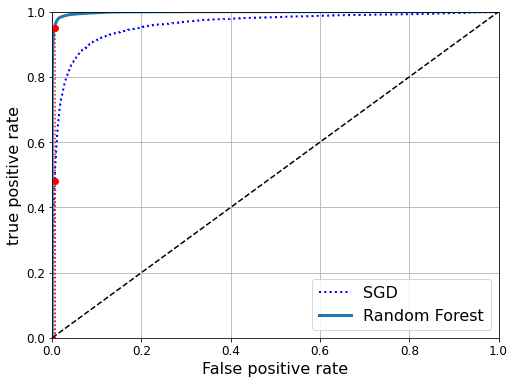

In [39]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [41]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [42]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

### 다중분류

* 이진 분류가 두개의 클래스를 구별하는 반면 다중분류기는 둘 이상의 클래스를 구별할 수 있다.      

  
* SDG , 랜덤포레스트, 나이브베이즈 일부 알고리즘은 여러개의 클래스를 직접처리할 수 있는 반면 , 로지스틱회귀나 SVM 같은 알고리즘은 이진분류만 가능하다.하지만 이진분류기를 여러개 사용해 다중클래스를 분류하는 기법도 많다.    


* 예를 들어 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지를 분류 시스템을 만들 수 있다. 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택 하면 된다. 이를 OVR(one versus rest/ OVA on versus all)전략이라고 한다.

* OVO(one versus one)전략은 0과 1구별, 0과 2구별 등 과 같이 각 숫자의 조합마마 이진 분류기를 훈련시키는 것이다. 클래스가 N개라면 분류기를 N*(N-1)/2개가 필요하다. Mnist문제에서는 45개의 분류기를 훈련시켜야 한다. 이미지 한나를 분류하려면 45개 분류기를 모두 통과시켜서 가장 많이 양성으로 분류된 클래스를 선택, 이 전략의 주요 장점은 각 분류기의 훈련에 전체 훈련세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것이다.

대부분 이진 분류 알고리즘에서는 OVR선호  , 다중 클래스 분류작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OVR, OVO를 실행한다.

In [43]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=int8)

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

내부에서 사이킷런이 OVO전략을 사용해 45개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택 

In [45]:
np.argmax(some_digit_scores) 

5

In [46]:
svm_clf.classes_ 

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

사이킷런에서 OVO , OVR을 사용하도록 강제하려면 oneVSonceClassifier , OneVsRestClassifier를 사용

In [47]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=int8)

In [48]:
len(ovr_clf.estimators_)

10

In [49]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=int8)

In [50]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### 에러분석

모델의 성능을 향상 시킬 수 있는 방법으로 에러의 종류를 분석하는 것 

In [57]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

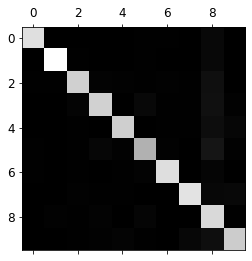

In [58]:
# matshow() 사용해서 시각화

plt.matshow(conf_mx , cmap = plt.cm.gray)
plt.show()

위 오차행렬을 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보인다. 숫자 5는 다른 숫자보다 어두워 보이는데 이는 데이터셋에 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이다. 

#### 그래프의 에러부분에 초점
먼저 오차 행렬의 각 값에 대응되는 클래스의 이미지 개수로 나누어 에러비율을 비교 

In [63]:
# n차원 array에서 축 합계를 구한 뒤, 반환 결과를 n차원으로 유지하기 위해서는 keepdims 인자를 True로 지정
row_sums = conf_mx.sum(axis =1 , keepdims = True)
norm_conf_mx = conf_mx / row_sums

다른 항목은 그대로 유지하고 주대각선만으로 0으로 채워서 그래프 생성 

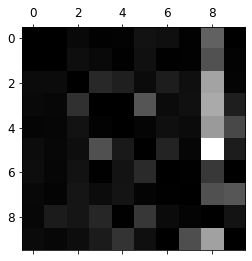

In [65]:
np.fill_diagonal(norm_conf_mx , 0)
plt.matshow(norm_conf_mx , cmap = plt.cm.gray)
plt.show()

행을 실제 클래스, 열은 예측 클래스   
오차행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다. 그래프를 살펴보면 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다.  

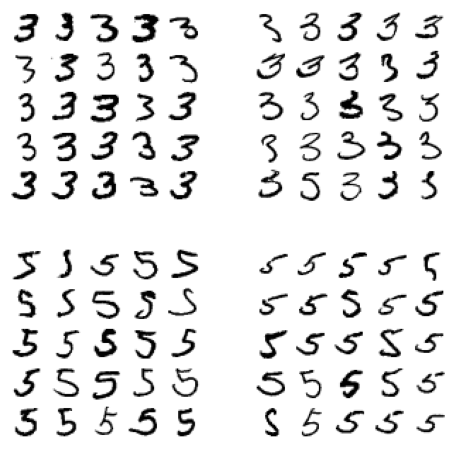

In [66]:
# 3과 5의 샘플

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]

X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

* 대부분의 잘못 분류된 이미지는 확실히 에러인것 같고 분류기가 실수 이유를 이해하기 어렵다.  원인은 선형 모델인 SGDClassifier를 사용했기 때문이다. 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산하다. 따라서 3과 5는 몇개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 된다. 

* 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치이다. 숫자 3을 쓸때 연결부위가 조금 왼쪽으로 치우치면 분류기가 5로 분류하고 반대도 마찬가지다.  


**즉 분류기는 이미지의 위치나 회전방향에 매우 민감** 3과 5의 에러를 줄이는 한가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것 

### 다중 레이블 분류

* 분류기가 샘플마다 여러개의 클래스를 출력해야 할때도 있다. 얼굴인식 분류기를 예로 들어보면 같은 사진에 여러 사람이 등장한다면 어떻게 해야 할까? 인식된 사람 마다 꼬리표를 붙여야 한다.   

* 분류기가 엘리스, 밥, 찰리 세얼굴을 인식하도록 훈련되었다고 가정한다면 분류기가 엘리스, 찰리 사진을 본다면 [1 , 0, 1]을 출력해야 한다. 이 처럼 여러 개의 이진 꼬리표를 출력하는 분류 시스템을 다중 레이블 분류시스템이라고 한다.

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [68]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
# 출력 시간이 오래 걸려 넘김 
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 값은 0.976410

코드는 모든 레이블의 가중치가 같다고 가정한 것이다. 특히 엘리스 사진이 밥이나 찰리 사진보다 훨씬 많다면 엘리스 사진에 대한 분류기의 점수에 더 높은 가중치를 둘것이다. 간단한 방법은 레이블 클래스의 지지도(즉 타깃 레이블에 속한 샘플 수)를 가중치로 주는 것이다. average = 'weighted' 코드

### 다중 출력 분류 
* 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한것 (즉 값을 두개 이상 가질 수 있다.)

MNIST이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 ranint() 함수를 사용하여 픽셀 강도에 잡음을 추가 


In [70]:
noise  = np.random.randint(0 ,100 , (len(X_train), 784))
X_train_mod = X_train + noise 

noise  = np.random.randint(0 ,100 , (len(X_test), 784))
X_test_mod = X_test + noise 

y_train_mod = X_train
y_test_mod = y_test

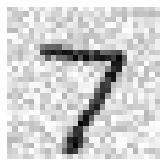

In [74]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.show()

분류기 훈련을 통해 이미지 개선 

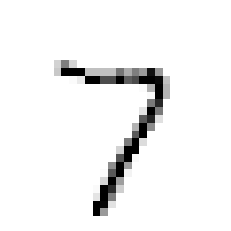

In [75]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plot_digit(clean_digit)